## One Shot Learning on Omniglot Dataset with Siamese Networks

Deep Learning has become one of the most sought after techniques for image classification tasks. 

A large amount of data is needed for building good predictive models. 

These models tend to overfit the data when very few amount of data is considered.

In this case, One Shot Learning model tends to perform better than other models.

It requires us to have just one training example of each class that we  want to predict on. The model is still trained on several instances, but they only have to be in the similar domain as our training example.

Siamese networks are a special type of neural network architecture. Instead of a model learning to classify its inputs, the neural networks learns to differentiate between two inputs. It learns the similarity between them.


<img src='images/siamese_net.jpeg' width="300" height="200">

One particularly interesting task is classification under the restriction that we may only observe a single example of each possible class before making a prediction about a test instance. 

This is called one-shot learning and it is the primary focus of our model presented in this work.

This network is not learning to classify an image directly to any of the output classes and is rather learning a similarity function, which takes two images as input and expresses how similar they are. Intuitively, this function just evaluates how well the network is distinguishing a given pair of images.

#### Siamese Network Architecture

A Siamese networks consists of two identical neural networks, each taking one of the two input images. The last layers of the two networks are then fed to a contrastive loss function , which calculates the similarity between the two images.

#### Omniglot Dataset

The OmniGlot Dataset is a collection of 1623 hand drawn characters from 50 international languages. Each alphabet in each language has 20 examples only. This is considered a ‘transpose’ of MNIST, where the number of classes are less (10), and the training examples are numerous. In OmniGlot, there are a very large number of classes, with few examples of each class. Each image is a gray scale image of resolution 105x105.

 

### Loading the Dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras import backend as K
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle

In [3]:
train_folders_path = os.path.join('images_background')
test_folders_path = os.path.join('images_evaluation')

In [4]:
len(os.listdir(train_folders_path))

31

In [5]:
def load_images(file_path):
    x_train = []
    y_train = []
    cat_dict = {}
    lang_dict = {}
    y_val = 0
    for folders in os.listdir(file_path):
        if not folders.startswith('.'):
            lang_folders = os.path.join(file_path,folders)
            lang_dict[folders] = [y_val,None]
            for char_folder in os.listdir(lang_folders):
                category_imgs = []
                if not char_folder.startswith('.'):
                    alphabet_folders = os.path.join(lang_folders,char_folder)
                    cat_dict[y_val] = [folders,char_folder]
                    for images in os.listdir(alphabet_folders):
                        if not images.startswith('.'):
                            alpha_image_path = os.path.join(alphabet_folders,images)
                            img = cv2.imread(alpha_image_path,cv2.IMREAD_GRAYSCALE)
                            category_imgs.append(img)
                            y_train.append(y_val)
                
                    x_train.append(np.stack(category_imgs))
                    y_val+=1
                    lang_dict[folders][1] = y_val - 1
                
    x_train = np.stack(x_train)
    y_train = np.vstack(y_train)
    return x_train,y_train,lang_dict,cat_dict

This function returns a tuple of 3 variables - training set/test set, target variables ,language dictionary with language as key and their ranges as value and a categories dictionary

In [6]:
x_train,y_train,lang_dict,category_dict = load_images(train_folders_path)

In [7]:
x_val,y_val,lang_dict_val,category_dict_val = load_images(test_folders_path)

In [8]:
a,b,c,d = x_train.shape
print(a,b,c,d)

964 20 105 105


In [9]:
y1 = y_train.tolist()
flat_list = [item for sublist in y1 for item in sublist]

Count of alphabets in each language in the dataset

In [10]:
from collections import Counter 
Counter(flat_list[:200])

Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20})

Various Languages that are present in the training set

In [11]:
lang_dict.keys()

dict_keys(['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)'])

Various Languages that are present in the validation set

In [12]:
lang_dict_val.keys()

dict_keys(['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic'])

### Utility function to generate pairs of images

Our input to the system will be a pair of images and the output will be a similarity score between 0 and 1. 

y_i = 1 => If both images are same, else they are 0.

We need to create pairs of images along with the target variable, to be fed as input to the Siamese Network.

In [13]:
def generate_pairs(no_of_pairs):
    
    x_input = x_train
    n_classes,n_chars,width,height = x_input.shape
    
    categories = np.random.choice(n_classes,size=(no_of_pairs,),replace=False)
    pairs = [np.zeros((no_of_pairs,height,width,1)) for cnt in range(2)]
    targets = np.zeros((no_of_pairs,1))
    
    targets[no_of_pairs//2:] = 1
    
    for i in range(no_of_pairs):
        category_1 = categories[i]
        index_1 = np.random.randint(0,n_chars)
        pairs[0][i,:,:,:] = x_input[category_1,index_1].reshape(height,width,1)
        
        index_2 = np.random.randint(0,n_chars)
        
        if i >= no_of_pairs//2:
            category_2 = category_1
        else:
            category_2 = (category_1 + np.random.randint(n_classes))% n_classes
        
        pairs[1][i,:,:,:] = x_input[category_2,index_1].reshape(height,width,1)
        
    return pairs,targets    

In [14]:
no_of_pairs = 10
pairs1,targets1 = generate_pairs(no_of_pairs)

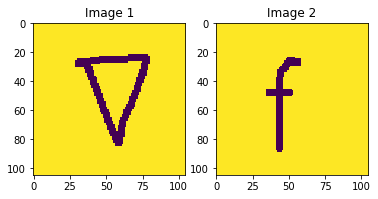

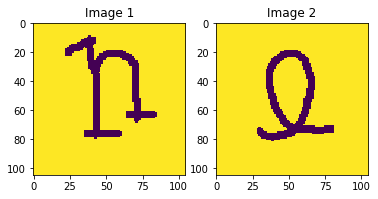

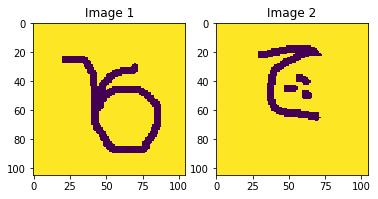

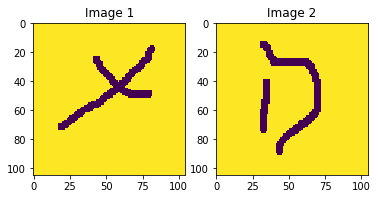

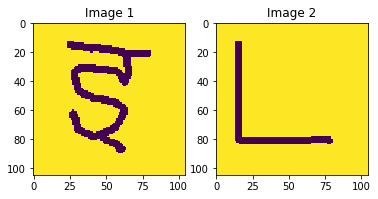

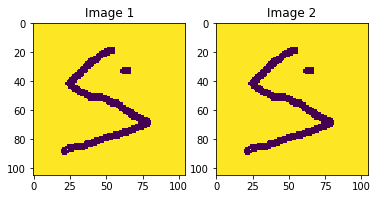

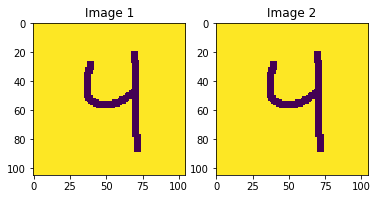

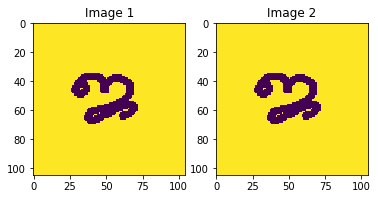

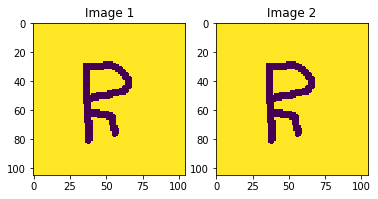

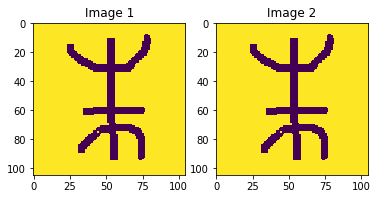

In [15]:
for i in range(no_of_pairs):
    fig=plt.figure()
    img1 = np.reshape(pairs1[0][i],(105,105))
    ax = plt.subplot(1,2,1)
    ax.set_title('Image 1')
    plt.imshow(img1)
    img2 = np.reshape(pairs1[1][i],(105,105))
    ax = plt.subplot(1,2,2)
    ax.set_title('Image 2')
    plt.imshow(img2)
    plt.show()

### Siamese Network Architecture

<img src='images/siamese_arch.png' width="1500" height="1500">

The different layers of Siamese Network are shown above.

The weights and the bias term are generated as mentioned in the paper http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf

In [16]:
def get_weights(input_dim):
    return np.random.normal(loc = 0.0, scale = 1e-2,size = input_dim)

In [17]:
def get_bias_term(input_dim):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = input_dim)

In [18]:
def generate_siamese_model(input_dim):
    first_input = Input(input_dim)
    second_input = Input(input_dim)
    
    model = Sequential()
    model.add(Conv2D(64,(10,10),activation = 'relu', input_shape = input_dim, 
                     kernel_initializer=get_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128,(7,7),activation = 'relu', input_shape = input_dim, 
                     kernel_initializer=get_weights, bias_initializer = get_bias_term, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128,(4,4),activation = 'relu', input_shape = input_dim, 
                     kernel_initializer=get_weights, bias_initializer = get_bias_term, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096,activation = 'sigmoid',
                    kernel_initializer=get_weights, bias_initializer = get_bias_term, kernel_regularizer=l2(2e-4)))
    
    first_model = model(first_input)
    second_model = model(second_input)
    
    l1_layer = Lambda(lambda x: K.abs(x[0] - x[1]))
    l1_distance = l1_layer([first_model,second_model])
    
    predictions = Dense(1,activation = 'sigmoid',bias_initializer = get_bias_term)(l1_distance)
    
    siamese_model = Model(inputs = [first_input,second_input], outputs = predictions)
    
    return siamese_model

In [19]:
siamese_model = generate_siamese_model((105, 105, 1))
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         170543680   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

In [20]:
optimizer = Adam(0.00006)
siamese_model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Utility function for performing One shot task

In One shot task, 'n' number of image pairs are generated in which in every image the same character is compared with 'n' number of other images to get similarity scores between 0 and 1. 

By repeating this procedure 'k' times, we can calculate the percentage of correct predictions as follows:

percent_correct = (100 * n_correct) / k

where k => total no. of trials and n_correct => no. of correct predictions out of k trials.

<img src='images/one.jpeg' width="500" height="500">

In [66]:
def one_shot_task(x_values,no_of_test_classes,language = None):
    if x_values == 'train':
        x_input = x_train
    else:
        x_input = x_val
        
    n_classes,n_chars,width,height = x_input.shape
    
    indices = np.random.randint(0,n_chars, size = no_of_test_classes)
    
    if language is not None:
        lower_bound,upper_bound = lang_dict_val[language]
        
        if N > upper_bound - lower_bound:
            raise ValueError('There are fewer characters than the given number of classes')
        categories = np.random.choice(range(lower_bound,upper_bound),size=(no_of_test_classes,),replace=False)
    else:
        categories = np.random.choice(range(n_classes),size=(no_of_test_classes,),replace=False)
    
    true_category = categories[0]
    
    ex1, ex2 = np.random.choice(n_chars,size=(2,),replace=False)
    
    test_image = np.asarray([x_input[true_category,ex1,:,:]] * no_of_test_classes).reshape(no_of_test_classes, width, height,1)
    support_set = x_input[categories,indices,:,:]
    support_set[0,:,:] = x_input[true_category,ex2]
    support_set = support_set.reshape(no_of_test_classes, width, height,1)
    targets = np.zeros((no_of_test_classes,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
    
    return pairs,targets

In [22]:
inputs1, targets1 = one_shot_task("train",20)

### Plots of image pairs genrated by one shot task in train set

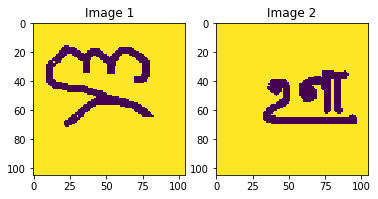

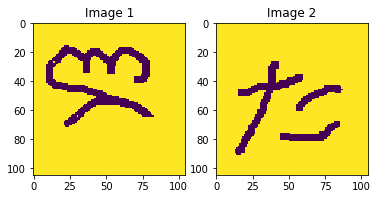

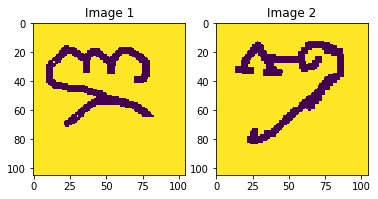

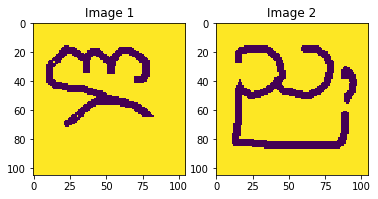

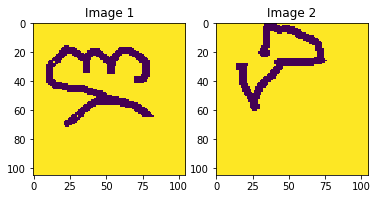

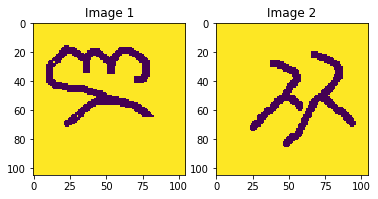

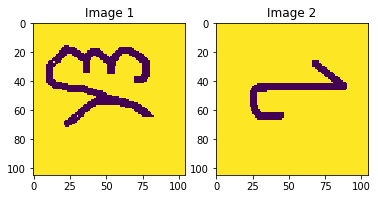

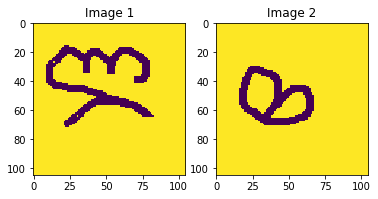

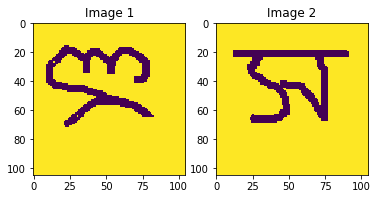

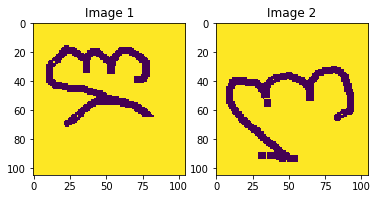

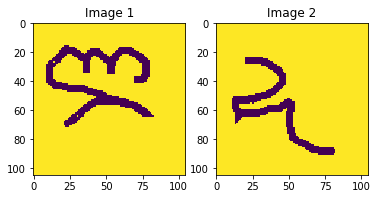

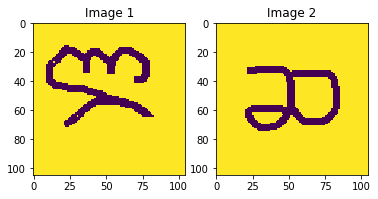

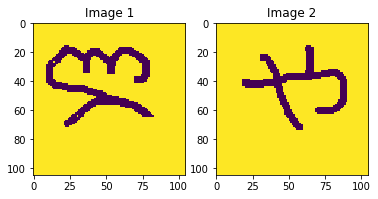

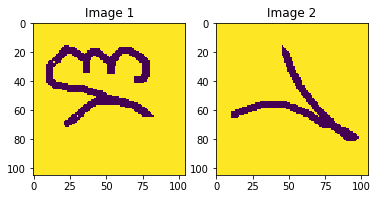

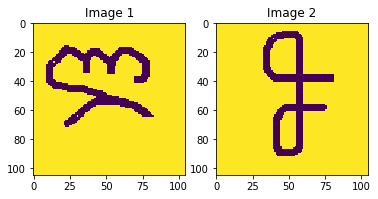

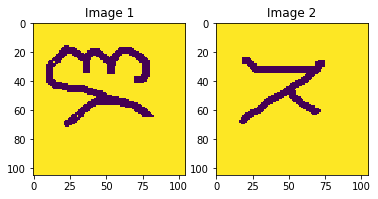

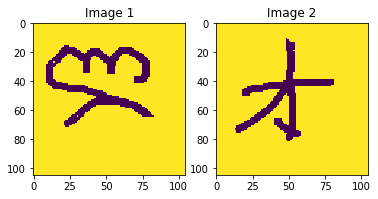

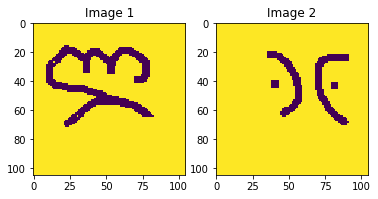

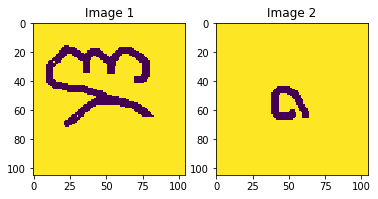

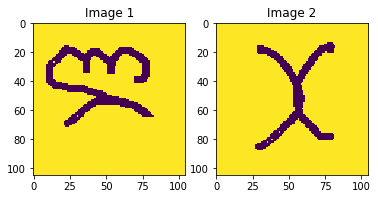

In [23]:
for i in range(20):
    fig=plt.figure()
    img1 = np.reshape(inputs1[0][i],(105,105))
    ax = plt.subplot(1,2,1)
    ax.set_title('Image 1')
    plt.imshow(img1)
    img2 = np.reshape(inputs1[1][i],(105,105))
    ax = plt.subplot(1,2,2)
    ax.set_title('Image 2')
    plt.imshow(img2)
    plt.show()

In [24]:
inputs2, targets2 = one_shot_task("val",20)

### Plots of image pairs genrated by one shot task in validation set

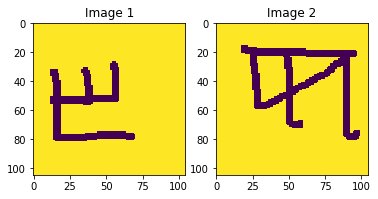

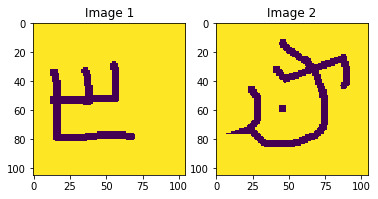

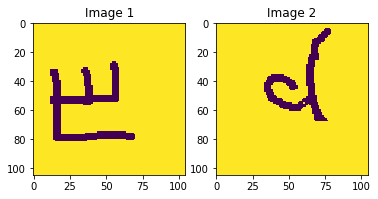

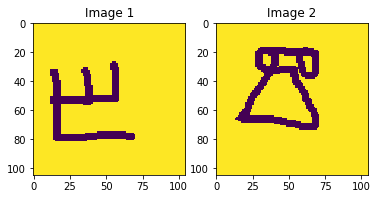

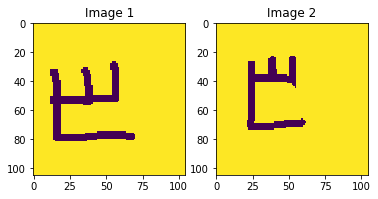

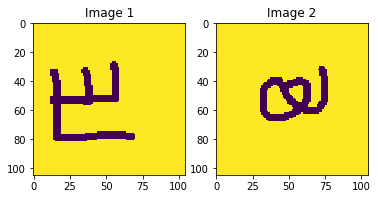

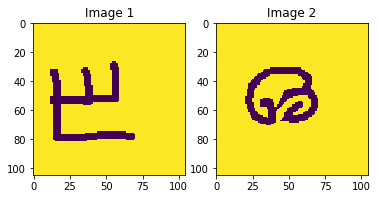

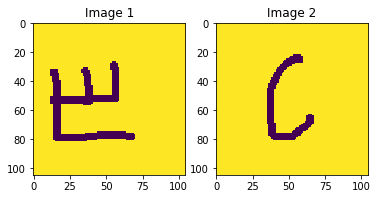

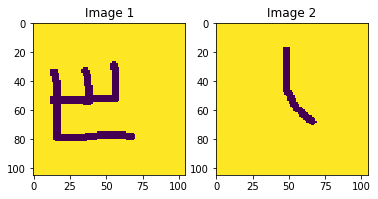

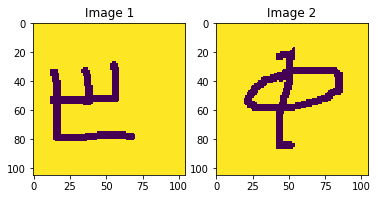

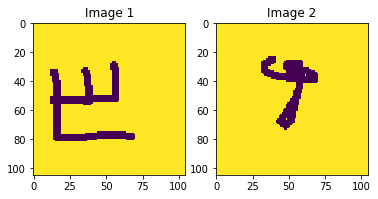

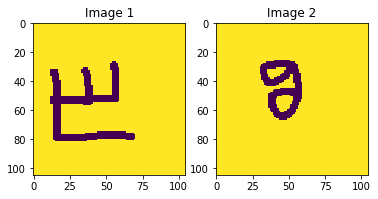

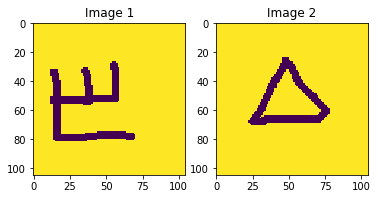

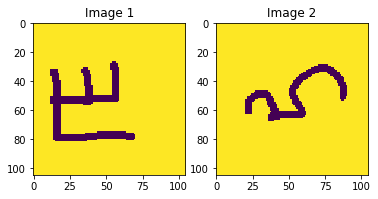

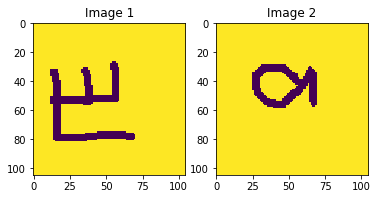

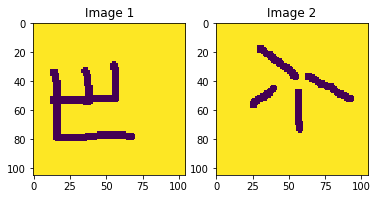

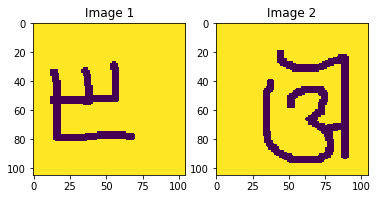

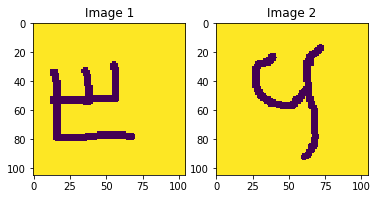

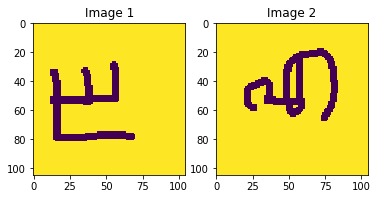

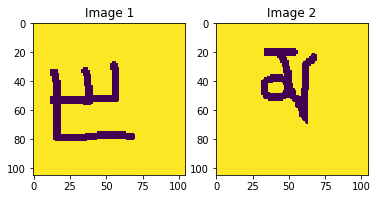

In [25]:
for i in range(20):
    fig=plt.figure()
    img1 = np.reshape(inputs2[0][i],(105,105))
    ax = plt.subplot(1,2,1)
    ax.set_title('Image 1')
    plt.imshow(img1)
    img2 = np.reshape(inputs2[1][i],(105,105))
    ax = plt.subplot(1,2,2)
    ax.set_title('Image 2')
    plt.imshow(img2)
    plt.show()

### Utility function for testing the One Shot Model

This function is used for testing the model on validation set to evaluate its performance

In [26]:
def test_one_shot_model(no_of_oneshot_tasks,x_values,no_of_test_classes,model):
    x_input = x_values
    correct_cnt = 0
    for i in range(no_of_oneshot_tasks):
        inputs,targets = one_shot_task(x_input,no_of_test_classes)
        prob_values = model.predict(inputs)
        if np.argmax(prob_values) == np.argmax(targets):
            correct_cnt+=1
        
    percent_correct = (100 * correct_cnt)/(no_of_oneshot_tasks)
    print('An accuracy of {} % is obtained for {} one shot tasks'.format(percent_correct,no_of_oneshot_tasks))
    
    return percent_correct    

In [27]:
evaluate_every = 100
no_of_pairs = 30
no_of_iter = 1000
no_of_test_classes = 20
no_of_one_shot_tasks = 100
best_acc = -1

### Testing the performance of model on validation set for 'n' number of iterations

In [60]:
start = datetime.now()
for i in range(1,no_of_iter+1):
    if i%25 == 0:
        print('Computing for {}th iteration'.format(i))
        print('Time for {} iterations is {} minutes'.format(i,(datetime.now() - start).seconds/60))
    inputs,targets = generate_pairs(no_of_pairs)
    loss = siamese_model.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        print('Train Loss at {}th iteration is {}'.format(i,loss))
        test_acc = test_one_shot_model(no_of_one_shot_tasks,'val',no_of_test_classes,siamese_model)
        if test_acc >= best_acc:
            print('Current best is {} and previous best is {}'.format(test_acc,best_acc))
            best_acc = test_acc

Computing for 25th iteration
Time for 25 iterations is 2.6166666666666667 minutes
Computing for 50th iteration
Time for 50 iterations is 5.9 minutes
Computing for 75th iteration
Time for 75 iterations is 8.983333333333333 minutes
Computing for 100th iteration
Time for 100 iterations is 12.0 minutes
Train Loss at 100th iteration is 1.2923134565353394
An accuracy of 32.0 % is obtained for 100 one shot tasks
Current best is 32.0 and previous best is -1
Computing for 125th iteration
Time for 125 iterations is 16.816666666666666 minutes
Computing for 150th iteration
Time for 150 iterations is 19.483333333333334 minutes
Computing for 175th iteration
Time for 175 iterations is 22.183333333333334 minutes
Computing for 200th iteration
Time for 200 iterations is 24.9 minutes
Train Loss at 200th iteration is 1.0773438215255737
An accuracy of 27.0 % is obtained for 100 one shot tasks
Computing for 225th iteration
Time for 225 iterations is 29.333333333333332 minutes
Computing for 250th iteration
T

In [62]:
print('Best accuracy that is obtained is {} %'.format(best_acc))

Best accuracy that is obtained is 50.0 %


### Baseline Model using Euclidean Distance

In this model, we calculate the L2 (or) Euclidean distance between two images. The images with minimum L2 distance are said to be more similar with each other.

In [63]:
def nearest_neighbours(pairs,targets):
    l2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        l2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(l2_distances) == np.argmax(targets):
        return 1
    return 0

### Testing the accuracy of Siamese Network using Nearest Neigbours as baseline model

In [73]:
def test_siamese_net_accuracy(no_of_test_classes,n_iter):
    no_of_correct = 0
    
    for i in range(n_iter):
        pairs,targets = one_shot_task("val",no_of_test_classes)
        correct = nearest_neighbours(pairs,targets)
        no_of_correct += correct
    return 100.0 * no_of_correct / n_iter

In [68]:
no_of_ways = np.arange(1,20,2)
trials = 50
test_one_shot_model(no_of_one_shot_tasks,'val',no_of_test_classes,siamese_model)

In [69]:
val_accs, train_accs,nn_accs = [], [], []
for n in no_of_ways:    
    val_accs.append(test_one_shot_model(trials,"val",n,siamese_model))
    train_accs.append(test_one_shot_model(trials,"train",n,siamese_model))
    nn_acc = test_siamese_net_accuracy(n, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print('-'*70)

An accuracy of 100.0 % is obtained for 50 one shot tasks
An accuracy of 100.0 % is obtained for 50 one shot tasks
NN Accuracy =  100.0
----------------------------------------------------------------------
An accuracy of 62.0 % is obtained for 50 one shot tasks
An accuracy of 74.0 % is obtained for 50 one shot tasks
NN Accuracy =  48.0
----------------------------------------------------------------------
An accuracy of 44.0 % is obtained for 50 one shot tasks
An accuracy of 68.0 % is obtained for 50 one shot tasks
NN Accuracy =  46.0
----------------------------------------------------------------------
An accuracy of 48.0 % is obtained for 50 one shot tasks
An accuracy of 48.0 % is obtained for 50 one shot tasks
NN Accuracy =  28.0
----------------------------------------------------------------------
An accuracy of 40.0 % is obtained for 50 one shot tasks
An accuracy of 46.0 % is obtained for 50 one shot tasks
NN Accuracy =  34.0
-----------------------------------------------------

In [75]:
no_of_ways = np.arange(1,20,2)
trials = 500
for n in no_of_ways:
    nn_acc1 = test_siamese_net_accuracy(n, trials)
    print('Accuracy at {} th iteration is {}'.format(n,nn_acc1))

Accuracy at 1 th iteration is 100.0
Accuracy at 3 th iteration is 62.4
Accuracy at 5 th iteration is 49.8
Accuracy at 7 th iteration is 40.2
Accuracy at 9 th iteration is 40.0
Accuracy at 11 th iteration is 34.0
Accuracy at 13 th iteration is 35.8
Accuracy at 15 th iteration is 30.0
Accuracy at 17 th iteration is 32.6
Accuracy at 19 th iteration is 31.6


### Testing the Siamese Network using Contrastive Loss as loss function

<img src='images/contrasive.jpeg' width="500" height="500">

Here Dw is defined as the euclidean distance between the outputs of the sister siamese networks and m is a margin value which is greater than 0. Having a margin indicates that dissimilar pairs that are beyond this margin will not contribute to the loss. 

In [76]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [77]:
siamese_model2 = generate_siamese_model((105, 105, 1))
siamese_model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         170543680   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]               
          

In [78]:
optimizer2 = Adam(0.00006)
siamese_model2.compile(loss = contrastive_loss, optimizer=optimizer2)

In [81]:
val_accs2 = []
trials = 50

for n in no_of_ways:    
    val_acc2 = test_one_shot_model(trials,"val",n,siamese_model2)
    val_accs2.append(val_acc2)
    print('Validation accuracy at {} th iteration is {} %'.format(n,val_acc2))

An accuracy of 100.0 % is obtained for 50 one shot tasks
Validation accuracy at 1 th iteration is 100.0 %
An accuracy of 30.0 % is obtained for 50 one shot tasks
Validation accuracy at 3 th iteration is 30.0 %
An accuracy of 18.0 % is obtained for 50 one shot tasks
Validation accuracy at 5 th iteration is 18.0 %
An accuracy of 24.0 % is obtained for 50 one shot tasks
Validation accuracy at 7 th iteration is 24.0 %
An accuracy of 14.0 % is obtained for 50 one shot tasks
Validation accuracy at 9 th iteration is 14.0 %
An accuracy of 8.0 % is obtained for 50 one shot tasks
Validation accuracy at 11 th iteration is 8.0 %
An accuracy of 6.0 % is obtained for 50 one shot tasks
Validation accuracy at 13 th iteration is 6.0 %
An accuracy of 6.0 % is obtained for 50 one shot tasks
Validation accuracy at 15 th iteration is 6.0 %
An accuracy of 8.0 % is obtained for 50 one shot tasks
Validation accuracy at 17 th iteration is 8.0 %
An accuracy of 6.0 % is obtained for 50 one shot tasks
Validation 

### Observations

The above model clearly seems to be overfit and is performing poorly on the validation set.

The model can be further improved by training it for more number of iterations. Currently, I have trained it for only 1000 iterations.

Many of the hyperparameters of the model can be tuned to avoid overfitting and also the model could be improved by varying the number of image pairs and the number of trials.

### References

https://sorenbouma.github.io/blog/oneshot/